**Importing Necessary Files**

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

def prep_dataset(X,y):
    X_prep = X.astype('float32')
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

**Importing the Dataset**

In [3]:
root = '../input/cell-images-for-detecting-malaria/cell_images/cell_images/'
para = '/Parasitized/'
uninf = '/Uninfected/'

os.listdir(root)

['Uninfected', 'Parasitized']

In [4]:
Parasitized = os.listdir(root+para)
Uninfected = os.listdir(root+uninf)

**Visualising the data**

/tmp/ipykernel_32/2027196399.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


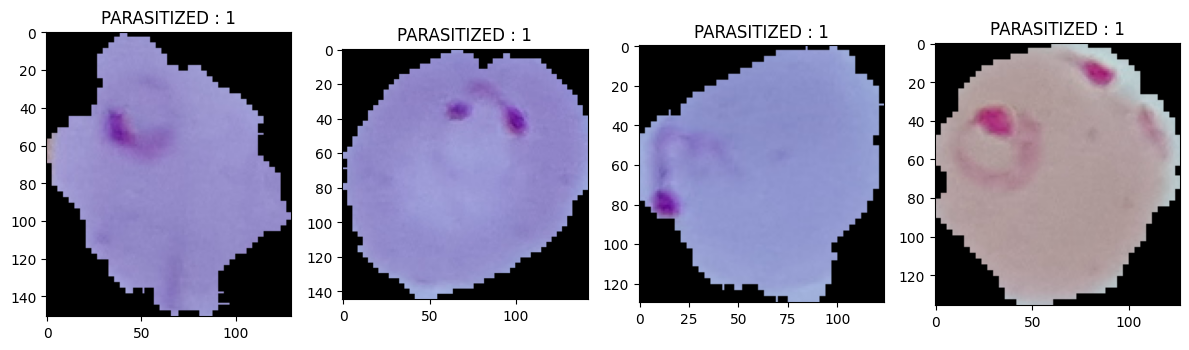

/tmp/ipykernel_32/2027196399.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


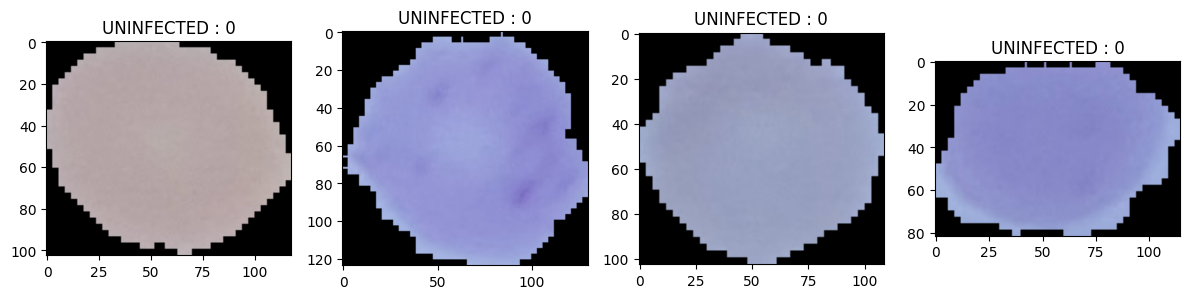

In [5]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    img = cv2.imread(root+para+ Parasitized[i])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(2, 4, i+1)
    img = cv2.imread(root+uninf+ Uninfected[i+1])
    plt.imshow(img)
    plt.title('UNINFECTED : 0')
    plt.tight_layout()
plt.show()

**Pre processing the data**

In [24]:
data = []
labels = []

for img in Parasitized:
    try:
        img_read = plt.imread(root+para+ img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(1)
    except:
        None
        
for img in Uninfected:
    try:
        img_read = plt.imread(root+uninf+ img)
        img_resize = cv2.resize(img_read, (50, 50))
        img_array = img_to_array(img_resize)
        data.append(img_array)
        labels.append(0)
    except:
        None

**Visualising the pre processed data**

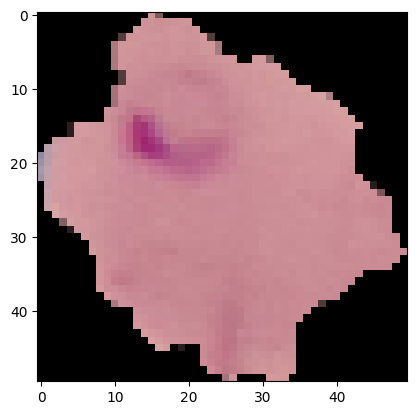

In [7]:
plt.imshow(data[0], cmap='gray')
plt.show()

**Shuffling the dataset**

This dataset has the parasitized cell images first followed by the images of the uninfected cells. In order to provide a better performance the dataset is shuffled randomly.

In [8]:
image_data = np.array(data)
labels = np.array(labels)

idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

In [9]:
image_data.shape

(27558, 50, 50, 3)

In [10]:
labels.shape

(27558,)

In [11]:
X, y = prep_dataset(image_data,labels)

**Splitting the dataset**

The processed and shuffled dataset is now splitted into training set, validation set and test sets. A split of 80%-10%-10% is followed respectiviley

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, shuffle=True,stratify=y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size=0.5, stratify=Y_test)

Y_test = np.argmax(Y_test, axis=1)

**Building a CNN Model**

A CNN model approach is used to tackle this problem. The model uses the adam optimiser with accuracy being the metric

In [21]:
model = models.Sequential() #Sequential Model

#ConvLayer(64 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',input_shape=X.shape[1:]))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(128 filters) + MaxPooling + BatchNormalization + Dropout
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

#ConvLayer(512 filters) + Dropout + ConvLayer(512 filters) + MaxPooling + BatchNormalization
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

#Flatten
model.add(layers.Flatten())

#3 Dense layers with 4000 hidden units
model.add(layers.Dense(4000,activation='relu'))
model.add(layers.Dense(4000,activation='relu'))
model.add(layers.Dense(4000,activation='relu'))

#Dense layer with 1000 hidden units
model.add(layers.Dense(1000,activation='relu'))

#Sigmoid layer for output
model.add(layers.Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 128)       36992     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 12, 12, 128)     

**Fitting the model**

The model is trained for 10 epochs with a batch size of 64 using accuracy as the metric.The model uses the adam optimiser with accuracy being the metric

In [13]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

history= model.fit(X_train,Y_train,
                 epochs=10,
                 batch_size=64,
                 validation_data=(X_val,Y_val))

Epoch 1/10
345/345 [==============================] - 509s 1s/step - loss: 1.0046 - accuracy: 0.7172 - val_loss: 1.0077 - val_accuracy: 0.5377
Epoch 2/10
345/345 [==============================] - 500s 1s/step - loss: 0.1882 - accuracy: 0.9382 - val_loss: 0.1392 - val_accuracy: 0.9554
Epoch 3/10
345/345 [==============================] - 504s 1s/step - loss: 0.1528 - accuracy: 0.9500 - val_loss: 0.1168 - val_accuracy: 0.9597
Epoch 4/10
345/345 [==============================] - 502s 1s/step - loss: 0.1498 - accuracy: 0.9521 - val_loss: 0.1209 - val_accuracy: 0.9594
Epoch 5/10
345/345 [==============================] - 500s 1s/step - loss: 0.1335 - accuracy: 0.9560 - val_loss: 0.1210 - val_accuracy: 0.9561
Epoch 6/10
345/345 [==============================] - 497s 1s/step - loss: 0.1300 - accuracy: 0.9578 - val_loss: 0.1219 - val_accuracy: 0.9630
Epoch 7/10
345/345 [==============================] - 496s 1s/step - loss: 0.1221 - accuracy: 0.9601 - val_loss: 0.1282 - val_accuracy: 0.9590

The progress in training accuracy and validation accuracy is compared

Text(0.5, 1.0, 'Loss')

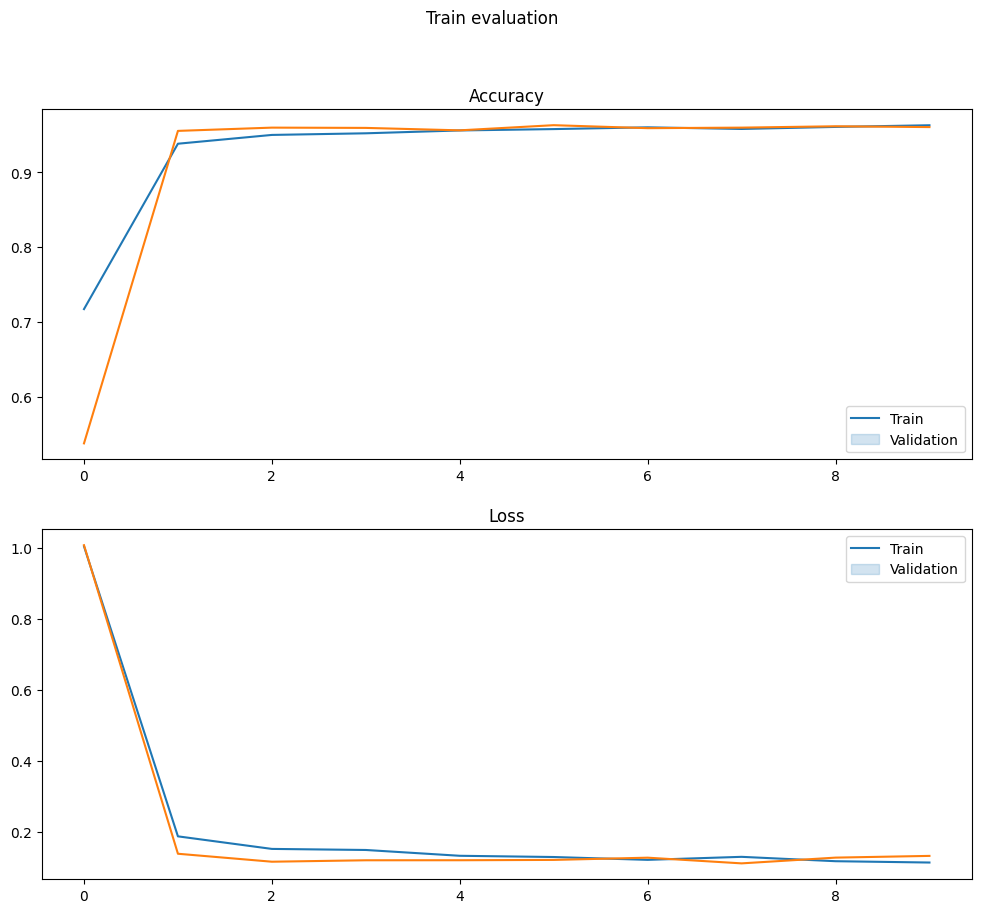

In [15]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')

**Prediction**

This model is used to predict values in the test set.

In [16]:
Y_pred = model.predict(X_test)

Y_pred = np.argmax(Y_pred, axis=1)

87/87 [==============================] - 12s 130ms/step


**Evaluating the prediction**

The predictions made on the test set is evaluated.The confusion matrix is also plotted

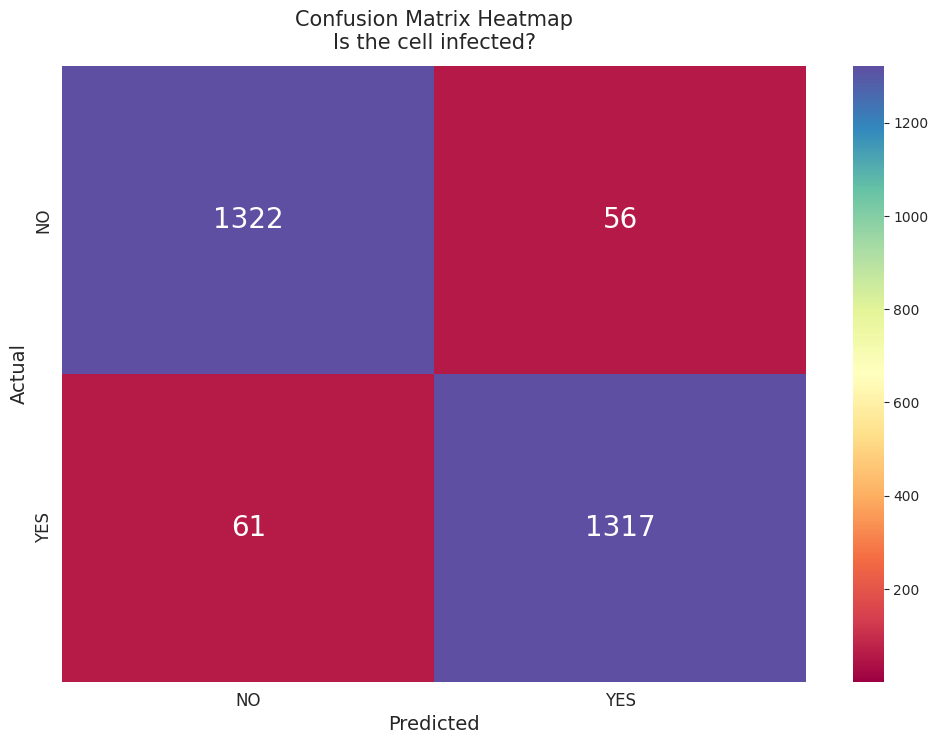

-Acuracy achieved: 95.75%
-Accuracy by model was: 96.29%
-Accuracy by validation was: 96.04%


In [18]:
conf_mat = confusion_matrix(Y_test,Y_pred)
sns.set_style(style='dark')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True,fmt='d', annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\nIs the cell infected?', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
heatmap.set_xticklabels(['NO','YES'], fontdict={'fontsize':12})
heatmap.set_yticklabels(['NO','YES'], fontdict={'fontsize':12})
plt.show()


print('-Acuracy achieved: {:.2f}%\n-Accuracy by model was: {:.2f}%\n-Accuracy by validation was: {:.2f}%'.
      format(accuracy_score(Y_test,Y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100))